# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
!pip install fastai2 monai kornia

In [0]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
import monai
from kornia.losses import FocalLoss
import gc

### fastai U-Net on these static images

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [5]:
np.random.seed(42)
ids = np.arange(101,151)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,10))
ids

array([[114, 140, 131, 146, 118, 149, 127, 126, 133, 120],
       [113, 105, 138, 109, 104, 107, 142, 147, 148, 116],
       [110, 117, 125, 135, 132, 101, 145, 128, 134, 106],
       [130, 112, 137, 102, 122, 103, 144, 136, 124, 141],
       [111, 123, 119, 150, 121, 108, 143, 115, 129, 139]])

Use cropping instead of resizing

In [0]:
def getMyopsDls(val_ids):
  myopsData = DataBlock(blocks=(ImageBlock, MaskBlock(codes = ['bg','lv','my','rv','ed','sc'])),
      get_items=get_image_files,
      splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in val_ids),
      get_y=lambda o: str(o).replace("images","masks"),
      item_tfms=CropPad(256),
      batch_tfms=aug_transforms(max_rotate=90))
  return myopsData.dataloaders(f'{path}/images',num_workers=8,batch_size=8)

**Attention!** The cropped version can have masks close to the edge and zooming or rotation can lead to additional masks at the edge because of padding in reflection mode

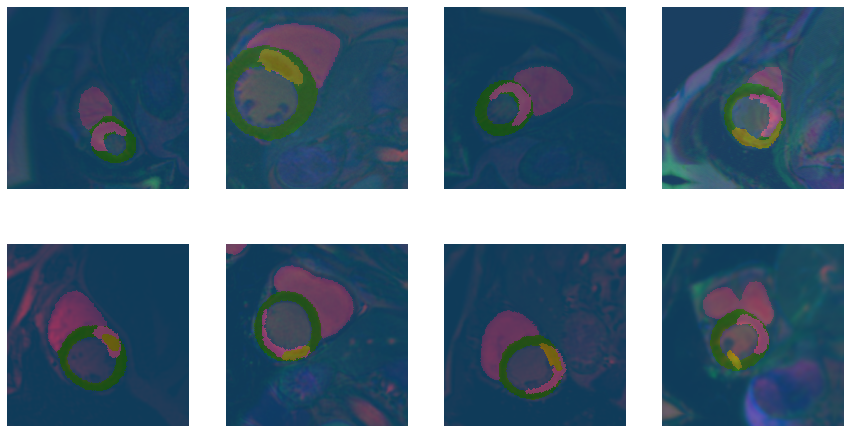

In [7]:
getMyopsDls(ids[0]).show_batch(figsize=(15,8))

In [0]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [0]:
def standard_trained_learner_cv(dl):
  learn = unet_learner(
    dl,
    resnet34,
    loss_func=FocalLoss(alpha=.5,reduction='mean'),
    metrics=[foreground_acc, *dices],
    cbs=CSVLogger(fname="/content/drive/My Drive/miccai2020/myops/03_crop_focal_unet_resnet34.trainLog.csv",append=True)
  )
  learn.lr_find()
  learn.fit_one_cycle(10,lr_max=1e-3)
  learn.unfreeze()
  learn.lr_find()
  learn.fit_one_cycle(10,lr_max=1e-4)
  return learn

epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.118166,0.060642,0.664311,0.733844,0.569810,0.482802,0.193878,0.062533,01:05
1,0.063339,0.048244,0.577879,0.814281,0.639659,0.299821,0.134222,0.147316,00:20
2,0.048263,0.040635,0.720820,0.786274,0.646711,0.710703,0.105570,0.190340,00:20
3,0.037283,0.035845,0.783487,0.854908,0.697638,0.646898,0.096300,0.217047,00:20
4,0.034071,0.028153,0.770643,0.856770,0.721728,0.680610,0.122232,0.291399,00:20
5,0.029347,0.026430,0.792781,0.872082,0.700771,0.732341,0.146441,0.406250,00:20
6,0.026805,0.024039,0.819419,0.886037,0.744545,0.746606,0.135622,0.451086,00:20
7,0.024704,0.024179,0.777140,0.877923,0.742386,0.770361,0.197533,0.442926,00:20
8,0.022240,0.021035,0.785818,0.879959,0.763433,0.817856,0.186564,0.529859,00:20
9,0.021329,0.020816,0.805764,0.883245,0.763728,0.820931,0.187903,0.515312,00:20


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.020557,0.019915,0.800803,0.882219,0.768699,0.826400,0.193417,0.532781,00:21
1,0.021764,0.020079,0.811067,0.881715,0.765485,0.847523,0.215056,0.530853,00:21
2,0.021534,0.019428,0.820707,0.887486,0.765520,0.799117,0.204280,0.535382,00:21
3,0.020450,0.021236,0.830558,0.881981,0.756207,0.769730,0.238264,0.524042,00:21
4,0.019778,0.019949,0.827308,0.885238,0.762178,0.792712,0.206165,0.517090,00:21
5,0.019026,0.019445,0.804940,0.892118,0.751930,0.806550,0.189099,0.567974,00:21
6,0.018286,0.020039,0.800090,0.887457,0.765446,0.842284,0.282684,0.512577,00:21
7,0.017115,0.019062,0.816246,0.889722,0.769171,0.809556,0.259383,0.548703,00:21
8,0.016413,0.018935,0.813550,0.889672,0.769526,0.807057,0.263733,0.561802,00:21
9,0.016010,0.018966,0.815407,0.890872,0.770375,0.809197,0.260143,0.558767,00:21


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.103043,0.045067,0.627136,0.768462,0.521395,0.666385,0.064388,0.134877,00:21
1,0.067486,0.042892,0.769735,0.768703,0.652244,0.714000,0.050305,0.195957,00:19
2,0.048417,0.044088,0.647320,0.606526,0.650577,0.655016,0.178646,0.247180,00:19
3,0.037560,0.027563,0.786870,0.851871,0.724672,0.780510,0.149383,0.398920,00:19
4,0.033019,0.029100,0.714267,0.861019,0.684248,0.737008,0.089344,0.345602,00:19
5,0.029103,0.028346,0.815190,0.836545,0.729728,0.788779,0.209323,0.405445,00:19
6,0.025687,0.027433,0.759272,0.857499,0.716935,0.780727,0.115548,0.334283,00:19
7,0.022290,0.027468,0.797080,0.858398,0.699001,0.794357,0.113784,0.384900,00:19
8,0.021493,0.025719,0.808568,0.858843,0.736815,0.799617,0.153434,0.416331,00:19
9,0.020137,0.025296,0.797497,0.860816,0.730207,0.807802,0.159041,0.394508,00:19


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.019807,0.025294,0.808221,0.862950,0.731266,0.812342,0.168687,0.395147,00:20
1,0.020206,0.025707,0.795629,0.863431,0.698009,0.807673,0.132945,0.369002,00:20
2,0.020216,0.025301,0.805223,0.864438,0.725208,0.805407,0.158343,0.413795,00:20
3,0.018577,0.028006,0.796910,0.866919,0.701419,0.788192,0.170887,0.377690,00:20
4,0.017821,0.026237,0.805178,0.868724,0.715040,0.808494,0.116318,0.365663,00:20
5,0.017156,0.023746,0.814069,0.871383,0.752139,0.817701,0.222091,0.436644,00:20
6,0.016192,0.024374,0.792457,0.871132,0.751951,0.815487,0.192061,0.434230,00:20
7,0.015591,0.025761,0.788266,0.869101,0.738096,0.807878,0.168827,0.404100,00:20
8,0.014982,0.026271,0.803446,0.866458,0.748490,0.809096,0.165067,0.422228,00:20
9,0.014668,0.025853,0.800657,0.867607,0.750561,0.808567,0.186108,0.427485,00:20


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.170670,0.111867,0.679290,0.742572,0.492120,0.376677,0.167783,0.167723,00:21
1,0.088620,0.055761,0.446184,0.617415,0.375871,0.462636,0.118633,0.249970,00:19
2,0.052825,0.028902,0.761198,0.838254,0.689184,0.718086,0.138069,0.389542,00:19
3,0.039284,0.028390,0.749161,0.848759,0.699251,0.713325,0.143500,0.426663,00:19
4,0.054128,0.036901,0.731667,0.807398,0.678296,0.634999,0.098476,0.326003,00:19
5,0.038967,0.026722,0.744216,0.847145,0.698724,0.745419,0.113663,0.413447,00:19
6,0.031006,0.024124,0.765571,0.849778,0.719694,0.737122,0.154224,0.448219,00:19
7,0.027377,0.024488,0.764701,0.853852,0.718909,0.755352,0.083391,0.423047,00:19
8,0.025283,0.022513,0.760427,0.862868,0.715897,0.758566,0.172103,0.475794,00:19
9,0.025008,0.022592,0.754774,0.863301,0.707798,0.757085,0.171159,0.478918,00:19


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.024462,0.022850,0.752236,0.862450,0.708784,0.753571,0.173743,0.478028,00:20
1,0.025749,0.024048,0.740725,0.852132,0.684057,0.756750,0.145193,0.430291,00:20
2,0.024858,0.022637,0.761244,0.859670,0.717603,0.752068,0.209775,0.511351,00:20
3,0.023905,0.023517,0.746951,0.854148,0.701793,0.759194,0.191982,0.518986,00:20
4,0.022898,0.021400,0.771770,0.864989,0.731473,0.783408,0.215256,0.529152,00:20
5,0.023144,0.020748,0.759167,0.867810,0.717493,0.775006,0.235290,0.538774,00:20
6,0.021704,0.020062,0.784949,0.871080,0.741825,0.781438,0.216556,0.548409,00:20
7,0.020444,0.020342,0.779154,0.870704,0.739561,0.776517,0.220521,0.538002,00:20
8,0.019654,0.020205,0.771460,0.876438,0.735418,0.778506,0.222284,0.538440,00:20
9,0.019376,0.020135,0.775925,0.873415,0.739565,0.780283,0.208498,0.544201,00:20


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.147601,0.058048,0.627277,0.768135,0.523599,0.692525,0.050008,0.084919,00:21
1,0.071757,0.058773,0.621435,0.807637,0.633005,0.452705,0.037798,0.142378,00:19
2,0.048194,0.032675,0.749934,0.852081,0.682864,0.752713,0.046923,0.347773,00:19
3,0.036799,0.033686,0.777894,0.858301,0.668107,0.827035,0.051105,0.333818,00:19
4,0.033529,0.030220,0.735880,0.863444,0.659731,0.791681,0.026535,0.346863,00:19
5,0.028750,0.027358,0.779088,0.884585,0.712161,0.823735,0.039489,0.436423,00:19
6,0.025913,0.026162,0.772004,0.873722,0.709343,0.811894,0.073118,0.408884,00:19
7,0.024643,0.024295,0.811779,0.884848,0.723179,0.847508,0.069792,0.467637,00:19
8,0.021640,0.023397,0.784225,0.894438,0.722541,0.807947,0.142737,0.490564,00:19
9,0.021534,0.023420,0.801029,0.892972,0.721508,0.844972,0.107909,0.493360,00:19


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.020527,0.023668,0.805680,0.889679,0.722275,0.850276,0.100681,0.492513,00:20
1,0.020762,0.022949,0.787258,0.896157,0.718196,0.816631,0.164587,0.492832,00:20
2,0.020885,0.025013,0.779030,0.882753,0.715838,0.826493,0.064837,0.483489,00:20
3,0.020286,0.023684,0.809855,0.883827,0.723658,0.849860,0.174948,0.510306,00:20
4,0.019402,0.023399,0.826380,0.894268,0.724051,0.867523,0.182745,0.497246,00:20
5,0.017914,0.024275,0.788401,0.898155,0.724010,0.804599,0.166494,0.491893,00:20
6,0.017067,0.023358,0.800117,0.897429,0.727484,0.842855,0.168965,0.513629,00:20
7,0.016737,0.023260,0.807797,0.898911,0.732263,0.841989,0.149219,0.504379,00:20
8,0.016165,0.022636,0.809630,0.900018,0.722309,0.851263,0.202555,0.513587,00:20
9,0.015614,0.023184,0.803536,0.898814,0.727272,0.841882,0.187380,0.500304,00:20


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.156368,0.094238,0.508998,0.654354,0.412545,0.318273,0.075488,0.000000,00:21
1,0.069793,0.059977,0.603365,0.797786,0.546168,0.570309,0.064573,0.026217,00:19
2,0.044536,0.047604,0.727558,0.822271,0.625006,0.691461,0.095358,0.156474,00:19
3,0.034908,0.040413,0.738317,0.816837,0.640969,0.750874,0.082916,0.153099,00:19
4,0.029243,0.039318,0.733360,0.847760,0.640433,0.755876,0.103241,0.305354,00:19
5,0.026880,0.038432,0.771360,0.840384,0.670092,0.709731,0.127309,0.309984,00:19
6,0.024114,0.040873,0.728558,0.855652,0.663400,0.757979,0.127131,0.343295,00:19
7,0.021738,0.033650,0.727799,0.849366,0.631638,0.790208,0.173970,0.470433,00:19
8,0.019998,0.031288,0.745486,0.857175,0.683871,0.800801,0.181156,0.376360,00:19
9,0.018947,0.029940,0.761509,0.865161,0.688958,0.798467,0.192344,0.448234,00:19


epoch,train_loss,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc,time
0,0.018885,0.032942,0.766852,0.858275,0.697353,0.792043,0.194370,0.439741,00:20
1,0.018758,0.034424,0.747617,0.859259,0.674072,0.772992,0.238611,0.407982,00:20
2,0.019366,0.039203,0.758818,0.840943,0.663291,0.781685,0.208496,0.469864,00:20
3,0.018859,0.033967,0.770563,0.855260,0.685589,0.789744,0.240430,0.412740,00:20
4,0.017809,0.031364,0.749773,0.851522,0.693500,0.751828,0.164944,0.456343,00:20
5,0.016953,0.031721,0.759907,0.867945,0.696423,0.794074,0.253399,0.456907,00:20
6,0.015957,0.031841,0.761869,0.873531,0.678358,0.801951,0.231266,0.494376,00:20
7,0.015216,0.030881,0.766103,0.871019,0.684946,0.804358,0.262162,0.419709,00:20
8,0.015113,0.030060,0.775929,0.874256,0.702221,0.807236,0.252200,0.460371,00:20
9,0.014650,0.030202,0.768796,0.875212,0.696215,0.806433,0.255956,0.476098,00:20


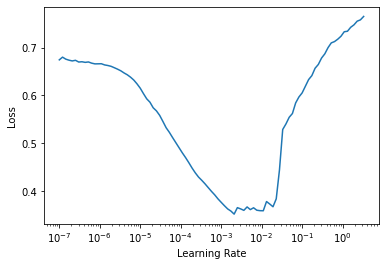

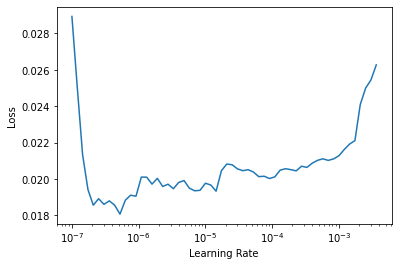

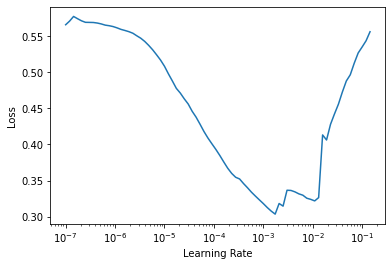

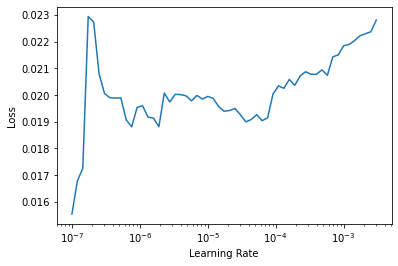

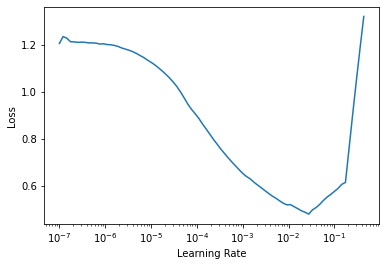

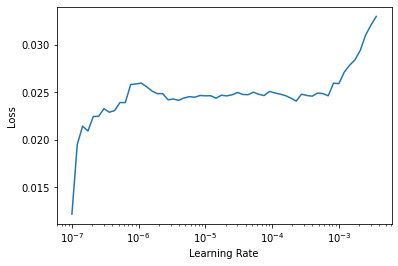

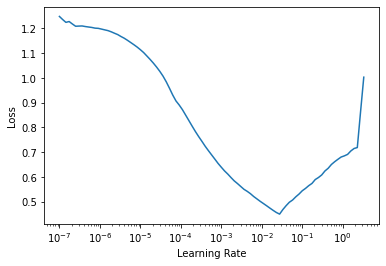

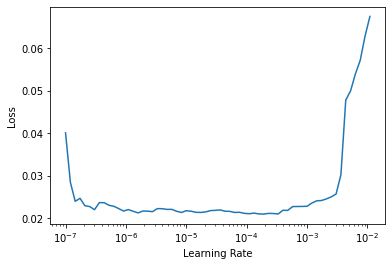

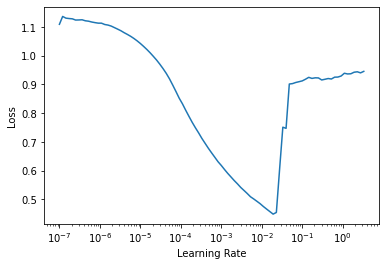

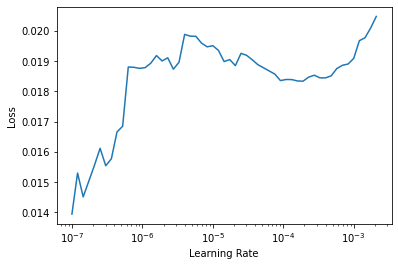

In [10]:
cv_results = list()
learn = None
dl = None
for x in ids:
  del learn
  del dl
  gc.collect()
  torch.cuda.empty_cache()
  dl = getMyopsDls(x)
  learn = standard_trained_learner_cv(dl)
  cv_results.append(learn.validate())

TypeError: ignored

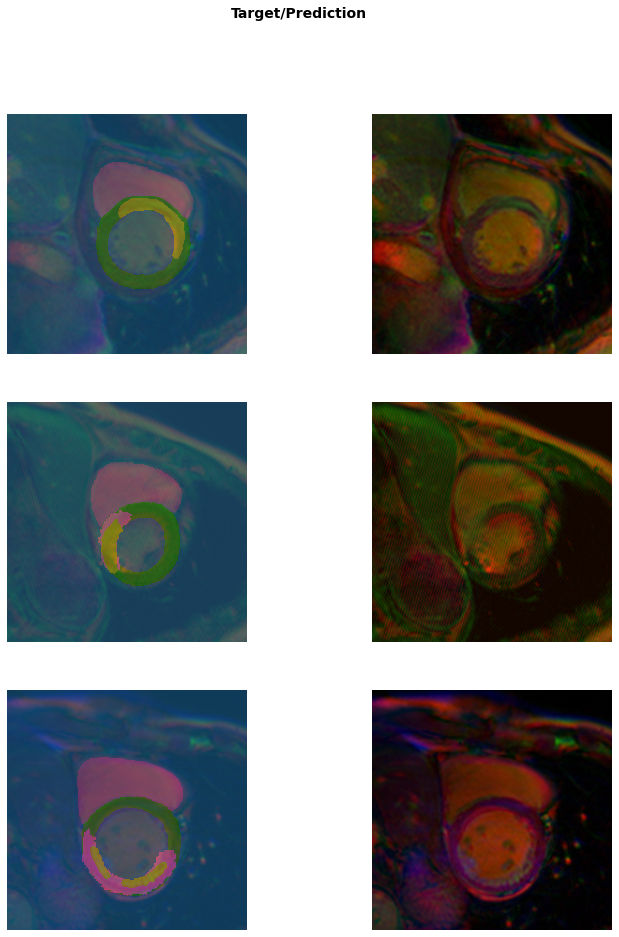

In [11]:
learn.show_results(figsize=(12,15))

In [0]:
learn.show_results(ds_idx=0, figsize=(15,15))

In [12]:
cv_results = pd.DataFrame(cv_results, columns=learn.recorder.metric_names[2:-1])
cv_results

,valid_loss,foreground_acc,diceLV,diceMY,diceRV,diceEd,diceSc
0,0.018966,0.815407,0.890872,0.770375,0.809197,0.260143,0.558767
1,0.025853,0.800657,0.867607,0.750561,0.808567,0.186108,0.427485
2,0.020135,0.775925,0.873415,0.739565,0.780283,0.208498,0.544201
3,0.023184,0.803536,0.898814,0.727272,0.841882,0.187380,0.500304
4,0.030202,0.768796,0.875212,0.696215,0.806433,0.255956,0.476098


In [0]:
cv_results.to_csv('/content/drive/My Drive/miccai2020/myops/03_crop_focal_unet_resnet34.cv_results.csv', index=False)

In [14]:
cv_results.mean()

valid_loss        0.023668
foreground_acc    0.792864
diceLV            0.881184
diceMY            0.736798
diceRV            0.809272
diceEd            0.219617
diceSc            0.501371
dtype: float64

In [0]:
cv_results_long = cv_results.stack().reset_index()
cv_results_long.columns = ['cv', 'metric', 'value']

In [0]:
import altair as alt

In [17]:
(alt.Chart(cv_results_long)
  .mark_point()
  .encode(x='metric', y='value', color='cv:N')
  .properties(width=600, height=300)
  .interactive())

alt.Chart(...)